# Ranking Performance Assessment

In this notebook, we have evaluated the "edge" provided by adding a Machine Learning method to the ranking step of this trading algorithm. We analyze the performance of:

* A classification model approach (which reduces to a filtering task)
* A time-series model approach
* A simplistic momentum strategy approach

Each of these approaches are benchmarked against an equally-weighted portfolio of all assets available in the given universe. The assets selected under each strategy are equally weighted to allow for equal comparison with the benchmark and across strategies.

In [1]:
%load_ext autoreload
%autoreload 2

# Analytics
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Utilities
import os
import joblib
from functools import reduce
from utils import *

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

In [2]:
data_path = os.path.dirname(os.getcwd()) + '/data'
data_prefix = '/broad_assets_'
test_path = data_path + '/classifier_test'
rets = pd.read_excel(data_path + data_prefix + 'weekly_rets.xlsx', index_col=0, parse_dates=True)

# Classifier Models

## Loading features data and organizing by asset

We have calculated the features that will be fed to the classifier model in a separate file and pulled those features for each of the trading days. We load them here and re-organize the tables from being feature-focused to asset-focused.

In [3]:
# Load test data for portfolio evaluation
features = ['lag1', 'roc', 'rsi', 'ewma', 'skew', 'kurtosis', 'macd_line', 'macd_signal', 'macd_histogram']
assets = ['Asset 1', 
          'Asset 2', 
          'Asset 3', 
          'Asset 4', 
          'Asset 5', 
          'Asset 6', 
          'Asset 7', 
          'Asset 8', 
          'Asset 9', 
          'Asset 10', 
          'Asset 11']
big_df = pd.DataFrame()
for feature in features:
    temp = pd.read_excel(test_path + data_prefix + feature + '_test.xlsx', sheet_name=0, index_col=0, parse_dates=True)
    temp_cols = [feature + '_' + asset for asset in assets]
    temp.columns = temp_cols
    big_df = pd.concat([big_df, temp], axis=1)

big_df

,lag1_Asset 1,lag1_Asset 2,lag1_Asset 3,lag1_Asset 4,lag1_Asset 5,lag1_Asset 6,lag1_Asset 7,lag1_Asset 8,lag1_Asset 9,lag1_Asset 10,...,macd_histogram_Asset 2,macd_histogram_Asset 3,macd_histogram_Asset 4,macd_histogram_Asset 5,macd_histogram_Asset 6,macd_histogram_Asset 7,macd_histogram_Asset 8,macd_histogram_Asset 9,macd_histogram_Asset 10,macd_histogram_Asset 11
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-29,0.0337,0.0734,-0.0067,-0.0004,0.0189,-0.0384,0.0361,0.0580,0.0067,0.0340,...,-0.0011,0.0001,0.0002,0.0029,0.0015,0.0004,-0.0008,0.0002,-0.0001,0.0011
2020-07-06,-0.0423,-0.0344,0.0282,0.0088,-0.0193,-0.0434,-0.0248,-0.0148,0.0108,0.0209,...,0.0042,-0.0011,-0.0002,0.0020,0.0023,0.0038,0.0074,-0.0010,-0.0000,0.0015
2020-07-13,0.0847,0.1324,-0.0192,-0.0049,0.0307,0.0646,0.0688,0.1535,-0.0168,0.0133,...,-0.0031,-0.0003,-0.0001,-0.0009,-0.0014,-0.0004,-0.0024,-0.0003,-0.0006,-0.0016
2020-07-20,-0.0152,-0.0012,0.0401,0.0034,-0.0548,-0.0708,-0.0259,-0.0098,-0.0057,0.0202,...,0.0021,-0.0006,-0.0001,0.0003,-0.0001,0.0009,-0.0001,-0.0002,0.0002,-0.0007
2020-07-27,0.0622,0.0661,0.0083,0.0021,0.0924,0.0174,0.0768,0.0168,-0.0134,0.0165,...,-0.0001,-0.0004,-0.0001,-0.0006,0.0012,-0.0005,0.0008,-0.0010,0.0031,0.0010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,-0.1012,-0.1221,0.1267,0.0494,-0.1713,-0.0276,-0.0737,-0.0862,-0.0351,0.0208,...,0.0040,-0.0007,-0.0003,0.0012,-0.0008,0.0017,0.0032,0.0004,0.0028,0.0038
2024-08-19,0.0607,0.0718,-0.0440,-0.0147,0.0210,0.0425,0.0431,0.0882,0.0093,0.0503,...,0.0034,-0.0002,-0.0004,0.0044,0.0006,0.0025,0.0025,-0.0006,0.0009,-0.0008
2024-08-26,0.1006,0.1346,0.0199,-0.0004,0.1037,0.0321,0.0931,0.0771,-0.0238,0.0239,...,-0.0027,-0.0008,-0.0002,0.0019,0.0012,-0.0005,-0.0015,0.0002,-0.0003,0.0025


In [4]:
asset_dfs = {}
for asset in assets:
    asset_cols = [col for col in big_df.columns if asset in col]
    asset_dfs[asset] = big_df[asset_cols]

# Cleaning up Asset 1 DataFrame
asset_dfs['Asset 1'] = asset_dfs['Asset 1'].drop(columns=[col for col in asset_dfs['Asset 1'].columns if '10' in col])
asset_dfs['Asset 1'] = asset_dfs['Asset 1'].drop(columns=[col for col in asset_dfs['Asset 1'].columns if '11' in col])

In [5]:
# Checking that all dataframes have the same number of features to pass to model.
for asset in assets:
    print(len(asset_dfs[asset].columns))

9
9
9
9
9
9
9
9
9
9
9


In [6]:
# Cleanup column names to pass to XGB model
for name, frame in asset_dfs.items():
    frame.columns = [col.replace('_' + name, '') for col in frame.columns]

In [7]:
asset_dfs['Asset 1']

,lag1,roc,rsi,ewma,skew,kurtosis,macd_line,macd_signal,macd_histogram
Date,,,,,,,,,
2020-06-29,0.0337,-0.0330,38.7166,0.0996,-0.1409,11.2923,-0.0027,-0.0031,0.0003
2020-07-06,-0.0423,0.0404,62.2076,0.0926,-0.1419,11.2861,0.0032,-0.0004,0.0035
2020-07-13,0.0847,-0.0016,54.2233,0.0830,-0.1416,11.2857,-0.0007,0.0001,-0.0009
2020-07-20,-0.0152,0.0816,76.3484,0.0746,-0.1426,11.2881,0.0016,0.0009,0.0007
2020-07-27,0.0622,0.0484,64.7365,0.0671,-0.1425,11.2923,-0.0010,-0.0002,-0.0008
...,...,...,...,...,...,...,...,...,...
2024-08-12,-0.1012,0.3593,38.7241,0.0638,-0.1576,10.5394,0.0013,-0.0014,0.0027
2024-08-19,0.0607,0.5582,59.3434,0.0628,-0.1586,10.5331,0.0054,0.0028,0.0025
2024-08-26,0.1006,0.5396,80.5849,0.0571,-0.1585,10.5372,0.0014,0.0025,-0.0011


## Generating Asset Selections and Equal-Weight Portfolio using Classifiers

We trained three different types of classifier models:

1. Decision Tree
1. Random Forest
1. XGBoost

For each model, we took a time-agnostic approach to organizing our training data. That is, instead of training the model on each asset independently, we expanded our training set by stacking each asset time-series on top of one another. We believe this approach is appropriate because classifier models are, by nature, time-agnostic. The models were trained to use the features to predict whether an asset with a given set of features would produce positive returns over the planned holding period (1-week for the broad asset universe). 

Below, we load the models we trained, generate the predictions over the test data set (data for which the models have not seen either during training or hyperparameter tuning), and then apply an equal-weighting methodology to the selected assets.

In [8]:
# Load the models
decision_tree = joblib.load('decision_tree.joblib')
random_forest = joblib.load('random_forest_model.joblib')
xgb = joblib.load('xgb_model.joblib')

In [9]:
# Generate Predictions and add them to selections DataFrame
decision_tree_selections = pd.DataFrame(columns=assets, index=asset_dfs['Asset 1'].index)
random_forest_selections = decision_tree_selections.copy()
xgb_selections = decision_tree_selections.copy()

for name, frame in asset_dfs.items():
    decision_tree_selections[name] = decision_tree.predict(frame)
    random_forest_selections[name] = random_forest.predict(frame)
    xgb_selections[name] = xgb.predict(frame)

In [10]:
display(decision_tree_selections)
display(random_forest_selections)
display(xgb_selections)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,0,0,1,1,0,0,0,0,1,1,0
2020-07-06,1,1,0,0,1,1,1,1,0,1,1
2020-07-13,0,0,1,1,0,0,0,0,1,1,0
2020-07-20,1,1,0,1,1,0,1,0,0,1,0
2020-07-27,0,0,1,1,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,1,1,1,1,0,0,1,1,1,1,1
2024-08-19,1,1,1,1,1,0,1,1,0,1,0
2024-08-26,1,1,0,0,1,1,1,1,0,1,1


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,0,0,1,1,0,0,0,0,1,1,0
2020-07-06,1,1,0,1,1,1,1,1,0,1,1
2020-07-13,0,0,1,1,0,0,0,0,0,1,0
2020-07-20,1,1,1,1,1,0,1,0,0,1,0
2020-07-27,0,0,1,1,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,1,1,1,1,0,0,1,1,1,1,1
2024-08-19,1,1,1,0,1,1,1,1,0,1,1
2024-08-26,1,1,0,0,1,1,1,1,0,1,1


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,0,0,1,1,0,0,0,0,1,1,0
2020-07-06,1,1,0,0,1,1,1,1,0,1,1
2020-07-13,0,0,1,1,0,0,0,0,1,1,0
2020-07-20,1,1,1,1,1,1,1,1,0,1,0
2020-07-27,0,0,1,1,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,1,1,0,1,0,0,1,1,0,1,1
2024-08-19,1,1,1,1,1,0,1,1,0,1,0
2024-08-26,1,1,0,0,1,1,1,1,0,1,1


In [11]:
decision_tree_counts = decision_tree_selections.sum(axis=1)
decision_tree_selections = decision_tree_selections.div(decision_tree_counts, axis=0)

random_forest_counts = random_forest_selections.sum(axis=1)
random_forest_selections = random_forest_selections.div(random_forest_counts, axis=0)

xgb_counts = xgb_selections.sum(axis=1)
xgb_selections = xgb_selections.div(xgb_counts, axis=0)

display(decision_tree_selections)
display(random_forest_selections)
display(xgb_selections)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,0.0000,0.0000,0.2500,0.2500,0.0000,0.0000,0.0000,0.0000,0.2500,0.2500,0.0000
2020-07-06,0.1250,0.1250,0.0000,0.0000,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250,0.1250
2020-07-13,0.0000,0.0000,0.2500,0.2500,0.0000,0.0000,0.0000,0.0000,0.2500,0.2500,0.0000
2020-07-20,0.1667,0.1667,0.0000,0.1667,0.1667,0.0000,0.1667,0.0000,0.0000,0.1667,0.0000
2020-07-27,0.0000,0.0000,0.1667,0.1667,0.1667,0.1667,0.0000,0.0000,0.0000,0.1667,0.1667
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.1111,0.1111,0.1111,0.1111,0.0000,0.0000,0.1111,0.1111,0.1111,0.1111,0.1111
2024-08-19,0.1250,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250,0.1250,0.0000,0.1250,0.0000
2024-08-26,0.1250,0.1250,0.0000,0.0000,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250,0.1250


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,0.0000,0.0000,0.2500,0.2500,0.0000,0.0000,0.0000,0.0000,0.2500,0.2500,0.0000
2020-07-06,0.1111,0.1111,0.0000,0.1111,0.1111,0.1111,0.1111,0.1111,0.0000,0.1111,0.1111
2020-07-13,0.0000,0.0000,0.3333,0.3333,0.0000,0.0000,0.0000,0.0000,0.0000,0.3333,0.0000
2020-07-20,0.1429,0.1429,0.1429,0.1429,0.1429,0.0000,0.1429,0.0000,0.0000,0.1429,0.0000
2020-07-27,0.0000,0.0000,0.1667,0.1667,0.1667,0.1667,0.0000,0.0000,0.0000,0.1667,0.1667
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.1111,0.1111,0.1111,0.1111,0.0000,0.0000,0.1111,0.1111,0.1111,0.1111,0.1111
2024-08-19,0.1111,0.1111,0.1111,0.0000,0.1111,0.1111,0.1111,0.1111,0.0000,0.1111,0.1111
2024-08-26,0.1250,0.1250,0.0000,0.0000,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250,0.1250


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,0.0000,0.0000,0.2500,0.2500,0.0000,0.0000,0.0000,0.0000,0.2500,0.2500,0.0000
2020-07-06,0.1250,0.1250,0.0000,0.0000,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250,0.1250
2020-07-13,0.0000,0.0000,0.2500,0.2500,0.0000,0.0000,0.0000,0.0000,0.2500,0.2500,0.0000
2020-07-20,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.0000,0.1111,0.0000
2020-07-27,0.0000,0.0000,0.1667,0.1667,0.0000,0.1667,0.0000,0.1667,0.0000,0.1667,0.1667
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.1429,0.1429,0.0000,0.1429,0.0000,0.0000,0.1429,0.1429,0.0000,0.1429,0.1429
2024-08-19,0.1250,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250,0.1250,0.0000,0.1250,0.0000
2024-08-26,0.1250,0.1250,0.0000,0.0000,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250,0.1250


In [12]:
eval_rets = rets.loc[xgb_selections.index]
eval_rets

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,-0.0423,-0.0344,0.0282,0.0088,-0.0193,-0.0434,-0.0248,-0.0148,0.0108,0.0209,-0.0333
2020-07-06,0.0847,0.1324,-0.0192,-0.0049,0.0307,0.0646,0.0688,0.1535,-0.0168,0.0133,0.0470
2020-07-13,-0.0152,-0.0012,0.0401,0.0034,-0.0548,-0.0708,-0.0259,-0.0098,-0.0057,0.0202,0.0010
2020-07-20,0.0622,0.0661,0.0083,0.0021,0.0924,0.0174,0.0768,0.0168,-0.0134,0.0165,0.0150
2020-07-27,-0.0077,-0.0513,0.0258,0.0012,0.0224,0.0320,0.0006,0.0223,-0.0445,0.1405,0.0592
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.0607,0.0718,-0.0440,-0.0147,0.0210,0.0425,0.0431,0.0882,0.0093,0.0503,0.0583
2024-08-19,0.1006,0.1346,0.0199,-0.0004,0.1037,0.0321,0.0931,0.0771,-0.0238,0.0239,-0.0377
2024-08-26,0.0020,-0.0266,0.0028,0.0064,0.0450,0.0540,0.0290,-0.0180,-0.0195,0.0097,0.0332


In [13]:
# Preliminary portfolio summaries to ensure consistency
decision_tree_rets = (eval_rets * decision_tree_selections).sum(axis=1).to_frame('Decision Tree Portfolio Returns')
random_forest_rets = (eval_rets * random_forest_selections).sum(axis=1).to_frame('Random Forest Portfolio Returns')
xgb_rets = (eval_rets * xgb_selections).sum(axis=1).to_frame('XGB Portfolio Returns')

classifier_rets = pd.concat([decision_tree_rets, random_forest_rets, xgb_rets], axis=1)
classifier_rets.describe()

,Decision Tree Portfolio Returns,Random Forest Portfolio Returns,XGB Portfolio Returns
count,220.0000,220.0000,220.0000
mean,0.0275,0.0267,0.0280
std,0.0243,0.0241,0.0240
min,-0.0156,-0.0133,-0.0113
25%,0.0126,0.0124,0.0133
50%,0.0224,0.0208,0.0222
75%,0.0384,0.0364,0.0382
max,0.1379,0.1379,0.1379


# Time Series Model

# Benchmarks - Equal Weight Portfolio and Simple Momentum

We provide a portfolio that is equally weighted across all available assets in the investible universe to serve as a benchmark to the classifier model strategies' returns.

## Equal-Weights Portfolio

In [14]:
equal_rets = (eval_rets * 1/len(eval_rets.columns)).sum(axis=1).to_frame('Equal Weight Portfolio Return')
equal_rets.describe()

,Equal Weight Portfolio Return
count,220.0000
mean,0.0026
std,0.0287
min,-0.1040
25%,-0.0132
50%,0.0028
75%,0.0196
max,0.0770


## Simple Momentum Portfolio

For the simple momentum benchmarks, we take a few naive approaches:

1. We look at the prior holding period's return of a given asset
1. We look at the trailing 1-month return of a given asset
1. We look at the trailing 3-month return of a given asset
1. We look at the trailing 1-year return of a given asset

If that return was positive, we select it for investment in the following period. Otherwise, it is excluded from the portfolio. With these selections in hand, we equally-weight the investments.

**Note:** At this time, we are not making a weighted decision with respect to results from each momentum metric.

In [15]:
lag1_selections = pd.DataFrame(np.where(rets.shift(1) > 0, 1, 0), columns=rets.columns, index=rets.index)
lag1_selections = lag1_selections.loc[xgb_selections.index]

lag4 = rets.rolling(window=4).apply(lambda x: np.prod(1 + x) - 1, raw=False)
lag4_selections = pd.DataFrame(np.where(lag4.shift(1) > 0, 1, 0), columns=rets.columns, index=rets.index)
lag4_selections = lag4_selections.loc[xgb_selections.index]

lag12 = rets.rolling(window=12).apply(lambda x: np.prod(1 + x) - 1, raw=False)
lag12_selections = pd.DataFrame(np.where(lag12.shift(1) > 0, 1, 0), columns=rets.columns, index=rets.index)
lag12_selections = lag12_selections.loc[xgb_selections.index]

lag52 = rets.rolling(window=52).apply(lambda x: np.prod(1 + x) - 1, raw=False)
lag52_selections = pd.DataFrame(np.where(lag52.shift(1) > 0, 1, 0), columns=rets.columns, index=rets.index)
lag52_selections = lag52_selections.loc[xgb_selections.index]

display(lag1_selections)
display(lag4_selections)
display(lag12_selections)
display(lag52_selections)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,1,1,0,0,1,0,1,1,1,1,1
2020-07-06,0,0,1,1,0,0,0,0,1,1,0
2020-07-13,1,1,0,0,1,1,1,1,0,1,1
2020-07-20,0,0,1,1,0,0,0,0,0,1,1
2020-07-27,1,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0,0,1,1,0,0,0,0,0,1,0
2024-08-19,1,1,0,0,1,1,1,1,1,1,1
2024-08-26,1,1,1,0,1,1,1,1,0,1,0


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,1,1,0,0,1,1,1,1,0,1,1
2020-07-06,0,1,1,1,1,0,1,1,0,1,1
2020-07-13,0,1,1,1,0,0,0,1,1,1,1
2020-07-20,1,1,1,1,0,0,1,1,0,1,1
2020-07-27,1,1,1,1,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0,0,1,1,0,1,0,0,0,1,0
2024-08-19,0,0,1,1,0,1,0,0,0,1,0
2024-08-26,1,0,1,1,0,1,1,1,0,1,0


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,1,1,0,0,1,1,1,1,0,1,1
2020-07-06,1,1,0,1,1,1,1,1,0,1,1
2020-07-13,1,1,0,1,1,1,1,1,0,1,1
2020-07-20,1,1,0,1,1,1,1,1,0,1,1
2020-07-27,1,1,0,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0,0,1,1,0,1,0,0,0,1,0
2024-08-19,1,0,1,1,0,1,0,0,0,1,0
2024-08-26,1,1,1,1,1,1,1,1,0,1,0


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,1,1,1,1,0,0,0,0,1,1,0
2020-07-06,0,1,1,1,0,0,0,0,1,1,0
2020-07-13,1,1,1,1,0,0,0,0,1,1,0
2020-07-20,0,1,1,1,0,0,0,0,1,1,0
2020-07-27,1,1,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,1,1,1,1,1,1,1,0,1,1,0
2024-08-19,1,1,1,1,1,1,1,1,1,1,0
2024-08-26,1,1,1,1,1,1,1,1,1,1,0


In [16]:
lag1_counts = lag1_selections.sum(axis=1)
lag1_selections = lag1_selections.div(lag1_counts, axis=0)

lag4_counts = lag4_selections.sum(axis=1)
lag4_selections = lag4_selections.div(lag4_counts, axis=0)

lag12_counts = lag12_selections.sum(axis=1)
lag12_selections = lag12_selections.div(lag12_counts, axis=0)

lag52_counts = lag52_selections.sum(axis=1)
lag52_selections = lag52_selections.div(lag52_counts, axis=0)

display(lag1_selections)
display(lag4_selections)
display(lag12_selections)
display(lag52_selections)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,0.1250,0.1250,0.0000,0.0000,0.1250,0.0000,0.1250,0.1250,0.1250,0.1250,0.1250
2020-07-06,0.0000,0.0000,0.2500,0.2500,0.0000,0.0000,0.0000,0.0000,0.2500,0.2500,0.0000
2020-07-13,0.1250,0.1250,0.0000,0.0000,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250,0.1250
2020-07-20,0.0000,0.0000,0.2500,0.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.2500,0.2500
2020-07-27,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.0000,0.1000,0.1000
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.0000,0.0000,0.3333,0.3333,0.0000,0.0000,0.0000,0.0000,0.0000,0.3333,0.0000
2024-08-19,0.1111,0.1111,0.0000,0.0000,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
2024-08-26,0.1250,0.1250,0.1250,0.0000,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250,0.0000


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,0.1250,0.1250,0.0000,0.0000,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250,0.1250
2020-07-06,0.0000,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250,0.1250,0.0000,0.1250,0.1250
2020-07-13,0.0000,0.1429,0.1429,0.1429,0.0000,0.0000,0.0000,0.1429,0.1429,0.1429,0.1429
2020-07-20,0.1250,0.1250,0.1250,0.1250,0.0000,0.0000,0.1250,0.1250,0.0000,0.1250,0.1250
2020-07-27,0.1111,0.1111,0.1111,0.1111,0.1111,0.0000,0.1111,0.1111,0.0000,0.1111,0.1111
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.0000,0.0000,0.2500,0.2500,0.0000,0.2500,0.0000,0.0000,0.0000,0.2500,0.0000
2024-08-19,0.0000,0.0000,0.2500,0.2500,0.0000,0.2500,0.0000,0.0000,0.0000,0.2500,0.0000
2024-08-26,0.1429,0.0000,0.1429,0.1429,0.0000,0.1429,0.1429,0.1429,0.0000,0.1429,0.0000


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,0.1250,0.1250,0.0000,0.0000,0.1250,0.1250,0.1250,0.1250,0.0000,0.1250,0.1250
2020-07-06,0.1111,0.1111,0.0000,0.1111,0.1111,0.1111,0.1111,0.1111,0.0000,0.1111,0.1111
2020-07-13,0.1111,0.1111,0.0000,0.1111,0.1111,0.1111,0.1111,0.1111,0.0000,0.1111,0.1111
2020-07-20,0.1111,0.1111,0.0000,0.1111,0.1111,0.1111,0.1111,0.1111,0.0000,0.1111,0.1111
2020-07-27,0.1111,0.1111,0.0000,0.1111,0.1111,0.1111,0.1111,0.1111,0.0000,0.1111,0.1111
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.0000,0.0000,0.2500,0.2500,0.0000,0.2500,0.0000,0.0000,0.0000,0.2500,0.0000
2024-08-19,0.2000,0.0000,0.2000,0.2000,0.0000,0.2000,0.0000,0.0000,0.0000,0.2000,0.0000
2024-08-26,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.0000,0.1111,0.0000


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2020-06-29,0.1667,0.1667,0.1667,0.1667,0.0000,0.0000,0.0000,0.0000,0.1667,0.1667,0.0000
2020-07-06,0.0000,0.2000,0.2000,0.2000,0.0000,0.0000,0.0000,0.0000,0.2000,0.2000,0.0000
2020-07-13,0.1667,0.1667,0.1667,0.1667,0.0000,0.0000,0.0000,0.0000,0.1667,0.1667,0.0000
2020-07-20,0.0000,0.2000,0.2000,0.2000,0.0000,0.0000,0.0000,0.0000,0.2000,0.2000,0.0000
2020-07-27,0.2000,0.2000,0.2000,0.2000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.0000,0.1111,0.1111,0.0000
2024-08-19,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.0000
2024-08-26,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.0000


In [17]:
# Preliminary portfolio summaries to ensure consistency
lag1_rets = (eval_rets * lag1_selections).sum(axis=1).to_frame('1-Period Momentum Portfolio')
lag4_rets = (eval_rets * lag4_selections).sum(axis=1).to_frame('1-Month Momentum Portfolio')
lag12_rets = (eval_rets * lag12_selections).sum(axis=1).to_frame('3-Month Momentum Portfolio')
lag52_rets = (eval_rets * lag52_selections).sum(axis=1).to_frame('1-Year Momentum Portfolio')

benchmark_rets = pd.concat([equal_rets, lag1_rets, lag4_rets, lag12_rets, lag52_rets], axis=1)
benchmark_rets.describe()

,Equal Weight Portfolio Return,1-Period Momentum Portfolio,1-Month Momentum Portfolio,3-Month Momentum Portfolio,1-Year Momentum Portfolio
count,220.0000,220.0000,220.0000,220.0000,220.0000
mean,0.0026,0.0019,0.0027,0.0027,0.0020
std,0.0287,0.0284,0.0288,0.0312,0.0290
min,-0.1040,-0.0945,-0.1298,-0.0873,-0.0729
25%,-0.0132,-0.0165,-0.0123,-0.0179,-0.0180
50%,0.0028,0.0030,0.0036,0.0025,0.0034
75%,0.0196,0.0189,0.0194,0.0212,0.0200
max,0.0770,0.1077,0.0978,0.1616,0.0853


# Performance Evaluation

In [26]:
all_rets = pd.concat([benchmark_rets, classifier_rets], axis=1)
calc_summary_statistics(all_rets, annual_factor=52, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T

Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,Equal Weight Portfolio Return,1-Period Momentum Portfolio,1-Month Momentum Portfolio,3-Month Momentum Portfolio,1-Year Momentum Portfolio,Decision Tree Portfolio Returns,Random Forest Portfolio Returns,XGB Portfolio Returns
Annualized Mean,0.1377,0.0992,0.1402,0.1397,0.1022,1.4324,1.3880,1.4561
Annualized Vol,0.2072,0.2050,0.2077,0.2249,0.2093,0.1750,0.1741,0.1731
Min,-0.1040,-0.0945,-0.1298,-0.0873,-0.0729,-0.0156,-0.0133,-0.0113
Max,0.0770,0.1077,0.0978,0.1616,0.0853,0.1379,0.1379,0.1379
Skewness,-0.3382,-0.1465,-0.4015,0.4598,0.0175,1.3778,1.4394,1.4895
Excess Kurtosis,1.0737,1.0277,2.4286,2.5687,0.0759,2.8178,3.0411,3.2911
Historical VaR (5.00%),-0.0405,-0.0506,-0.0429,-0.0462,-0.0472,-0.0006,-0.0019,-0.0009
Annualized Historical VaR (5.00%),-0.2921,-0.3652,-0.3096,-0.3331,-0.3404,-0.0040,-0.0137,-0.0066
Historical CVaR (5.00%),-0.0624,-0.0634,-0.0656,-0.0608,-0.0573,-0.0065,-0.0070,-0.0052
Annualized Historical CVaR (5.00%),-0.4500,-0.4572,-0.4727,-0.4381,-0.4134,-0.0467,-0.0505,-0.0379


As we can see in this performance summary table, the classifier models outperform the benchmarks on just about every metric.

* **Annualized Mean Returns:** The classifier models realize 10x the annualized returns over the benchmark strategies.

* **Max and Min Period Returns:** The classifier strategies pick the outperforming portfolios throughout the observation period with respect to all benchmarks except the 3-month lookback momentum strategy. Additionally, the minimum return periods are all significantly smaller than all benchmark strategies. These stats highlight the selection power of these models.

* **Volatility and Value-At-Risk:** The classifier-driven strategies reduce volatility and significantly lower Value-At-Risk throughout the observation period. Though we note that Value-At-Risk is a questionable metric to report in this context as we are dynamically selecting securities in each portfolio.

* **Skewness & Kurtosis:** The classifier strategies produce return distributions with significantly greater positive skew compared to most of the benchmark strategies. Notably, the 1-month and 3-month lookback periods provide a reasonably strong positive skew in returns.

* **Max Drawdown:** The max drawdown realized across any of the classifier-based strategies is -1.5%. The best performing classifier, XGBoost, only has a maximum drawdown of -1.35%

**Note:** The current performance evaluation does not capture intra-week volatility (i.e: Day-to-day volatility). Will need to update this summary to capture that.

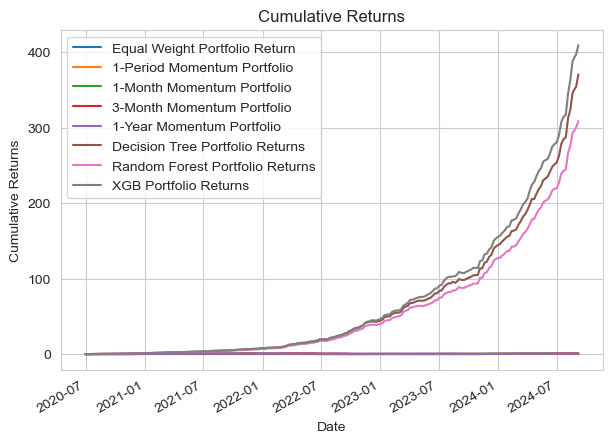

In [27]:
calc_cumulative_returns(all_rets)

The cumulative returns of the classifier model-based strategies dwarf the cumulative returns of the benchmark models. To provide a better visual comparison, we split out the two groups of cumulative returns below.

None

None

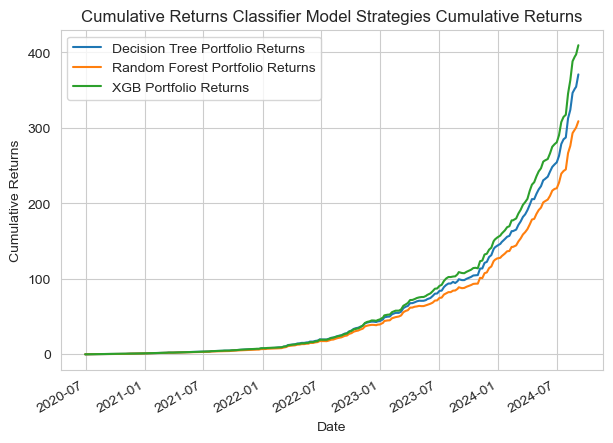

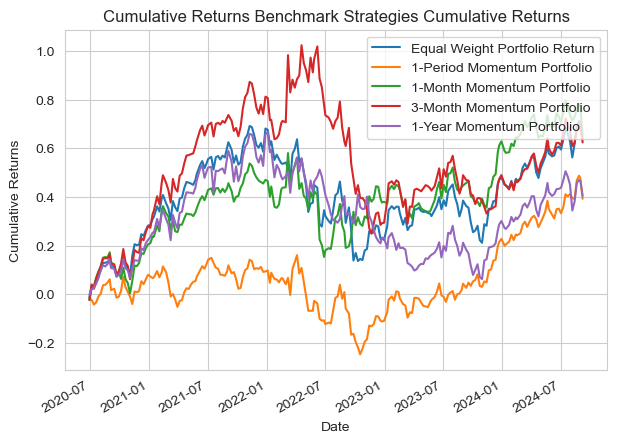

In [29]:
display(calc_cumulative_returns(classifier_rets, name='Classifier Model Strategies Cumulative Returns'), 
        calc_cumulative_returns(benchmark_rets, name='Benchmark Strategies Cumulative Returns'))